Ce code entraîne des modèles XGBoost pour prédire les valeurs de diverses cibles basées sur des caractéristiques météorologiques, en évaluant leurs performances avec des métriques telles que le RMSE, le MAE et le R². Les modèles sont sauvegardés et l'importance des caractéristiques est visualisée pour analyse.

Training model for target column: 2R-P01
RMSE for 2R-P01: 1.977056089504132
MAE for 2R-P01: 2.6257250101474305
R² for 2R-P01: 0.9029463529586792
Training model for target column: VL-P01
RMSE for VL-P01: 3.9223480008607194
MAE for VL-P01: 8.861272984703115
R² for VL-P01: 0.9795221090316772
Training model for target column: PL-P01
RMSE for PL-P01: 1.7491532915377426
MAE for PL-P01: 2.3067794080148607
R² for PL-P01: 0.9680929183959961
Training model for target column: 2R-P10
RMSE for 2R-P10: 1.352990308459378
MAE for 2R-P10: 0.8212699049485761
R² for 2R-P10: 0.8774970769882202
Training model for target column: VL-P10
RMSE for VL-P10: 1.5793120205281275
MAE for VL-P10: 1.4173106330450025
R² for VL-P10: 0.9626002907752991
Training model for target column: PL-P10
RMSE for PL-P10: 1.1586902138286046
MAE for PL-P10: 0.7549626651761472
R² for PL-P10: 0.8959344029426575
Training model for target column: 2R-P12
RMSE for 2R-P12: 2.461041748642075
MAE for 2R-P12: 3.390238317604733
R² for 2R-P12: 0.

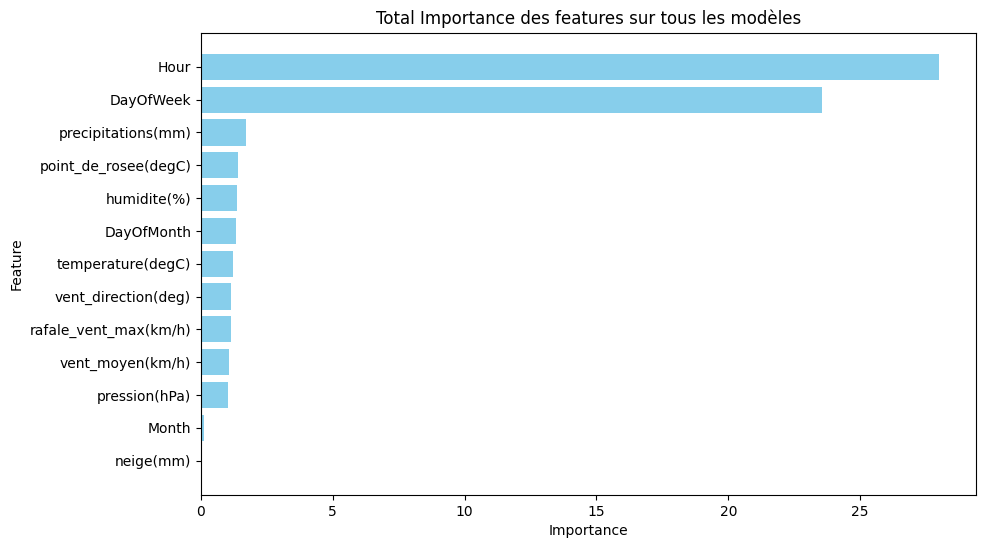

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

data = pd.read_csv('1month_meteo_data_en.csv')

data['Datetime'] = pd.to_datetime(data['Datetime'])

# Extraction du jour du mois depuis la colonne 'Datetime' et ajout de la colonne 'DayOfMonth'
data['DayOfMonth'] = data['Datetime'].dt.day


features = ['Hour', 'DayOfWeek', 'DayOfMonth', 'Month', 'temperature(degC)', 'point_de_rosee(degC)', 
                'humidite(%)', 'precipitations(mm)', 'neige(mm)', 'vent_direction(deg)', 
                'vent_moyen(km/h)', 'rafale_vent_max(km/h)', 'pression(hPa)']

target_columns = [col for col in data.columns if col.startswith(('VL', 'PL', '2R'))]

feature_importance_accumulator = np.zeros(len(features))
total_mae = 0
total_r2 = 0
total_rmse = 0
n_models = len(target_columns)

models_folder = "xgboost_regressor_11month"
os.makedirs(models_folder, exist_ok=True)

for vehicle_column in target_columns:
    print(f"Training model for target column: {vehicle_column}")
    
    X = data[features]
    y = data[vehicle_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
    model.fit(X_train, y_train)
    
    model_path = os.path.join(models_folder, f'xgboost_{vehicle_column}.joblib')
    joblib.dump(model, model_path)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE for {vehicle_column}: {rmse}")
    print(f"MAE for {vehicle_column}: {mae}")
    print(f"R² for {vehicle_column}: {r2}")
    
    total_rmse += rmse
    total_mae += mae
    total_r2 += r2

    feature_importances = model.feature_importances_
    feature_importance_accumulator += feature_importances

avg_rmse = total_rmse / n_models
avg_mae = total_mae / n_models
avg_r2 = total_r2 / n_models

print(f"\nAverage RMSE across all models: {avg_rmse}")
print(f"Average MAE across all models: {avg_mae}")
print(f"Average R² across all models: {avg_r2}")

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance_accumulator
}).sort_values(by='Importance', ascending=False)

print("\nTotal Feature Importance across all models:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Total Importance des features sur tous les modèles')
plt.gca().invert_yaxis()
plt.show()

Utiliser des modèles XGBoost pour prédire des valeurs basées sur des données météorologiques prétraitées et compiler les prédictions dans un DataFrame.

Les parametres a determiner sont : start_date, end_date, models_folder.

Les modeles que ca soit d un mois ou d extended ou 3 months.

In [57]:
import os
import pandas as pd
import joblib
from meteostat import Point, Hourly
from datetime import datetime

def predict_xgboost_regressor(start_date, end_date, models_folder, location):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    meteo_data = Hourly(location, start, end).fetch()

    meteo_data['DayOfWeek'] = meteo_data.index.dayofweek
    meteo_data['Hour'] = meteo_data.index.hour
    meteo_data['DayOfMonth'] = meteo_data.index.day
    meteo_data['Month'] = meteo_data.index.month

    meteo_data.rename(columns={
        'temp': 'temperature(degC)',
        'dwpt': 'point_de_rosee(degC)',
        'rhum': 'humidite(%)',
        'prcp': 'precipitations(mm)',
        'snow': 'neige(mm)',
        'wdir': 'vent_direction(deg)',
        'wspd': 'vent_moyen(km/h)',
        'wpgt': 'rafale_vent_max(km/h)',
        'pres': 'pression(hPa)',
        'tsun': 'ensoleillement(H)'
    }, inplace=True)

    required_columns = ['Hour', 'DayOfWeek', 'DayOfMonth', 'Month', 'temperature(degC)', 
                        'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                        'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                        'rafale_vent_max(km/h)', 'pression(hPa)']
    
    meteo_data = meteo_data[required_columns]

    predictions_df = pd.DataFrame(index=meteo_data.index)
    predictions_df['Datetime'] = meteo_data.index

    for model_filename in os.listdir(models_folder):
        if model_filename.endswith('.joblib'):
            column_name = model_filename.replace('.joblib', '')
            model = joblib.load(os.path.join(models_folder, model_filename))
            predictions = model.predict(meteo_data)
            predictions_df[column_name] = predictions
            non_datetime_columns = predictions_df.select_dtypes(exclude=['datetime']).columns
            predictions_df[non_datetime_columns] = predictions_df[non_datetime_columns].round().astype('Int64')

    return predictions_df

location = Point(44.8069, -0.6133, 20)  # Localisation de Talence, près de Bordeaux
predictions = predict_xgboost_regressor(
    start_date='2022-12-20', 
    end_date='2023-01-04', 
    models_folder='./xgboost_regressor_3month',  # Remplacer par le chemin du dossier des modèles XGBoost
    location=location
)

print(predictions)


                               Datetime  xgboost_2R-P01  xgboost_2R-P02  \
time                                                                      
2022-12-20 00:00:00 2022-12-20 00:00:00               2               1   
2022-12-20 01:00:00 2022-12-20 01:00:00               0               0   
2022-12-20 02:00:00 2022-12-20 02:00:00               2               1   
2022-12-20 03:00:00 2022-12-20 03:00:00               0               0   
2022-12-20 04:00:00 2022-12-20 04:00:00               0               0   
...                                 ...             ...             ...   
2023-01-03 20:00:00 2023-01-03 20:00:00              14               8   
2023-01-03 21:00:00 2023-01-03 21:00:00               8               6   
2023-01-03 22:00:00 2023-01-03 22:00:00               3               4   
2023-01-03 23:00:00 2023-01-03 23:00:00               2               0   
2023-01-04 00:00:00 2023-01-04 00:00:00               2              -1   

                     xgb

Affichage des prédictions:

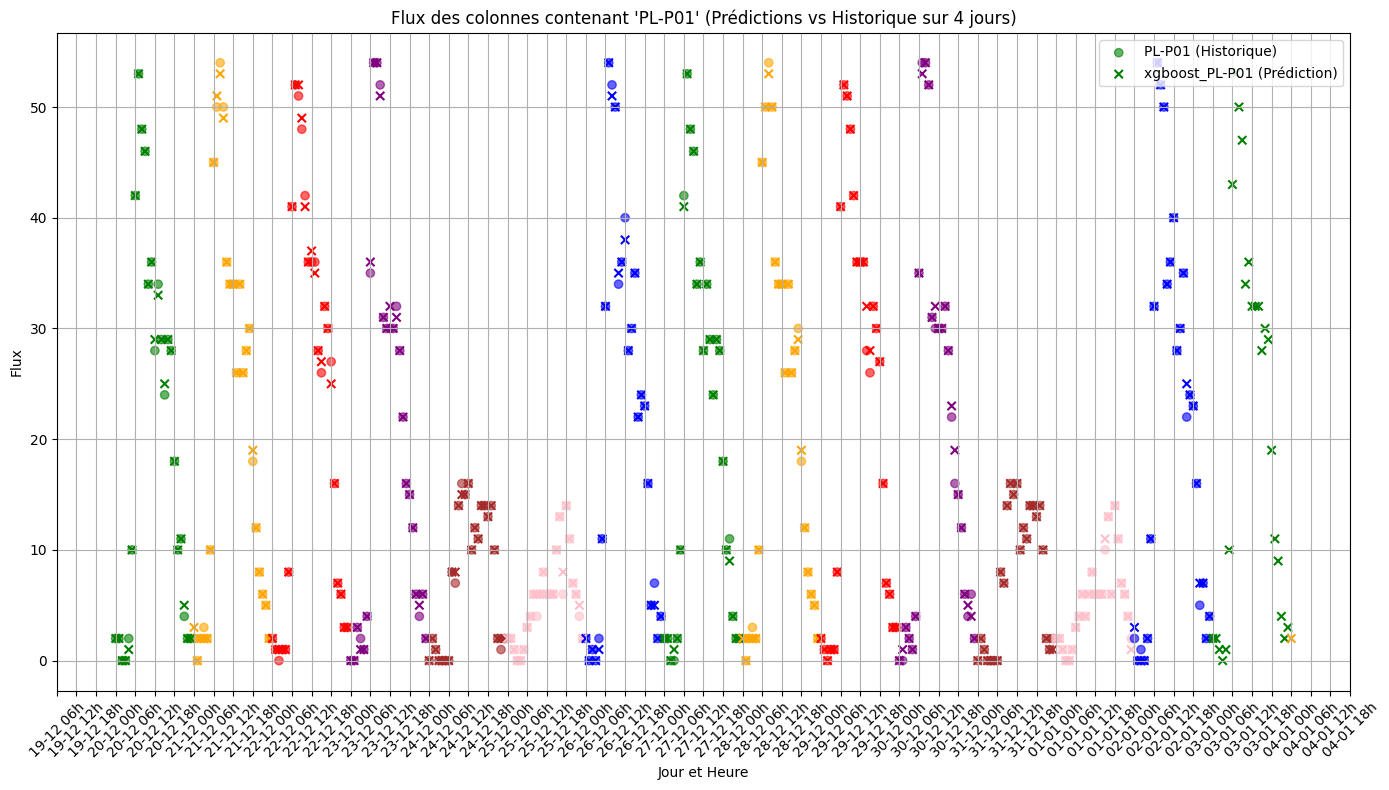

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

days_of_week = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red', 4: 'purple', 5: 'brown', 6: 'pink'}

def plot_regression_predictions_vs_history(predictions, previous_data=None, pattern=None, days=4):
    if pattern is None:
        print("Veuillez spécifier un motif pour filtrer les colonnes.")
        return
    
    columns_to_plot = [col for col in predictions.columns if pattern in col]
    if len(columns_to_plot) == 0:
        print(f"Aucune colonne trouvée avec le motif '{pattern}' dans les données de prédiction.")
        return

    predictions = predictions.loc[:, ~predictions.columns.duplicated()]
    if previous_data is not None:
        previous_data = previous_data.loc[:, ~previous_data.columns.duplicated()]

    try:
        predictions['Datetime'] = pd.to_datetime(predictions['Datetime'], errors='coerce')
        if previous_data is not None:
            previous_data['Datetime'] = pd.to_datetime(previous_data['Datetime'], errors='coerce')
    except Exception as e:
        print(f"Erreur lors de la conversion de 'Datetime': {e}")
        return

    last_days = predictions['Datetime'].max() - pd.Timedelta(days=days)
    predictions = predictions[predictions['Datetime'] >= last_days]
    if previous_data is not None:
        previous_data = previous_data[previous_data['Datetime'] >= last_days]

    predictions['DayOfWeek'] = predictions['Datetime'].dt.weekday.map(days_of_week)
    if previous_data is not None:
        previous_data['DayOfWeek'] = previous_data['Datetime'].dt.weekday.map(days_of_week)

    if predictions['Datetime'].isna().sum() > 0:
        print(f"Attention : {predictions['Datetime'].isna().sum()} valeurs 'Datetime' non valides détectées dans les prédictions.")
    if previous_data is not None and previous_data['Datetime'].isna().sum() > 0:
        print(f"Attention : {previous_data['Datetime'].isna().sum()} valeurs 'Datetime' non valides détectées dans les données historiques.")

    plt.figure(figsize=(14, 8))

    if previous_data is not None:
        for col in columns_to_plot:
            historical_col = col.replace("xgboost_", "")  # Ajustement pour les colonnes historiques
            if historical_col in previous_data.columns:
                plt.scatter(previous_data['Datetime'], previous_data[historical_col], 
                            c=previous_data['Datetime'].dt.weekday.map(colors), 
                            label=f'{historical_col} (Historique)', alpha=0.6)

    for col in columns_to_plot:
        plt.scatter(predictions['Datetime'], predictions[col], 
                    c=predictions['Datetime'].dt.weekday.map(colors), 
                    label=f'{col} (Prédiction)', marker='x')

    ax = plt.gca()
    
    # Ajustement pour afficher les heures de façon plus espacée
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Afficher chaque 6 heures
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %Hh'))  # Format jour et heure

    plt.xticks(rotation=45, fontsize=10)  # Ajuster la rotation et la taille des labels pour lisibilité
    plt.xlabel('Jour et Heure')
    plt.ylabel('Flux')
    plt.title(f"Flux des colonnes contenant '{pattern}' (Prédictions vs Historique sur 4 jours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()  # Ajustement pour éviter le chevauchement des labels
    plt.show()

# Exemple d'utilisation
df = pd.read_csv('3month_meteo_data_en.csv')
plot_regression_predictions_vs_history(predictions, previous_data=df, pattern='PL-P01', days=15)  


Finalement, on calcule le mae sur la dernier semaine d'historique.

Cette métrique s'est montré efficace.

In [54]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import joblib
from meteostat import Point, Hourly
from datetime import timedelta


def predict_xgboost_regressor(start_date, end_date, models_folder, location):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    meteo_data = Hourly(location, start, end).fetch()

    meteo_data['DayOfWeek'] = meteo_data.index.dayofweek
    meteo_data['Hour'] = meteo_data.index.hour
    meteo_data['DayOfMonth'] = meteo_data.index.day
    meteo_data['Month'] = meteo_data.index.month

    # Renommer les colonnes pour correspondre aux noms utilisés dans le modèle
    meteo_data.rename(columns={
        'temp': 'temperature(degC)',
        'dwpt': 'point_de_rosee(degC)',
        'rhum': 'humidite(%)',
        'prcp': 'precipitations(mm)',
        'snow': 'neige(mm)',
        'wdir': 'vent_direction(deg)',
        'wspd': 'vent_moyen(km/h)',
        'wpgt': 'rafale_vent_max(km/h)',
        'pres': 'pression(hPa)',
        'tsun': 'ensoleillement(H)'
    }, inplace=True)

    # Sélection des colonnes requises
    required_columns = ['Hour', 'DayOfWeek', 'DayOfMonth', 'Month', 'temperature(degC)', 
                        'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                        'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                        'rafale_vent_max(km/h)', 'pression(hPa)']
    
    meteo_data = meteo_data[required_columns]

    # Création du DataFrame pour les prédictions
    predictions_df = pd.DataFrame(index=meteo_data.index)
    predictions_df['Datetime'] = meteo_data.index

    # Charger et appliquer chaque modèle XGBoost sauvegardé
    for model_filename in os.listdir(models_folder):
        if model_filename.endswith('.joblib'):
            column_name = model_filename.replace('.joblib', '')
            model = joblib.load(os.path.join(models_folder, model_filename))
            predictions = model.predict(meteo_data)
            predictions_df[column_name] = predictions
            non_datetime_columns = predictions_df.select_dtypes(exclude=['datetime']).columns
            predictions_df[non_datetime_columns] = predictions_df[non_datetime_columns].round().astype('Int64')

    return predictions_df

df = pd.read_csv('3month_meteo_data_en.csv', parse_dates=['Datetime'])

last_date = df['Datetime'].max()
start_date = last_date - timedelta(days=7)
end_date = last_date + timedelta(days=1)
location = Point(44.8069, -0.6133, 20)

predictions = predict_xgboost_regressor(
    start_date=start_date, 
    end_date=end_date,
    models_folder='./xgboost_regressor_3month',  # Chemin des modèles XGBoost
    location=location
)
last_two_weeks_data = df.tail(14 * 24)
last_week = last_two_weeks_data.iloc[-7 * 24:]  # Dernière semaine
predictions = predictions.tail(7*24)
target_columns = [col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')]

# Assurez-vous que les noms des colonnes des prédictions et des vraies valeurs sont dans le même ordre
prediction_columns = [f"xgboost_{col}" for col in target_columns]

# Réorganiser les colonnes des prédictions pour correspondre à celles des vraies valeurs
predicted_values = predictions[prediction_columns].values
real_values = last_week[target_columns].values
mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE) entre les vraies valeurs et les prédictions XGBoost : {mae:.4f}")


Mean Absolute Error (MAE) entre les vraies valeurs et les prédictions XGBoost : 9.0865
